# Notebook para análisis y visualización de tokens

Este notebook permite graficar el total de tokens por año, por año y mes agrupados por canal, y un gráfico de líneas de tokens totales por mes-año.

## Importar librerías necesarias

Importamos pandas para manipulación de datos y matplotlib/seaborn para visualización.

In [1]:
import os
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/Users/andrestrepo/Documents/repos_personal/poc-summary/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

True

In [3]:
login(token = os.environ.get("HF_TOKEN") )

dataset_name = "AndresR2909/youtube_transcriptions_summaries_2025_gpt4.1"

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [4]:
splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
#sel_columns = ["channel_name","video_id","publish_date","year","month","number_of_tokenks","duration","text","summary"]
df_test = pd.read_parquet(f"hf://datasets/{dataset_name}/" + splits["test"])#, columns=sel_columns)
df_train = pd.read_parquet(f"hf://datasets/{dataset_name}/" + splits["train"])#, columns= sel_columns)

In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221 entries, 0 to 220
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   channel_name       221 non-null    object 
 1   video_id           221 non-null    object 
 2   source             221 non-null    object 
 3   publish_date       158 non-null    object 
 4   duration           221 non-null    float64
 5   last_update_date   221 non-null    object 
 6   title              221 non-null    object 
 7   text               221 non-null    object 
 8   year               221 non-null    int64  
 9   month              158 non-null    float64
 10  number_of_tokenks  221 non-null    int64  
 11  prompt             221 non-null    object 
 12  summary            221 non-null    object 
 13  key_terms          221 non-null    object 
 14  __index_level_0__  221 non-null    int64  
dtypes: float64(2), int64(3), object(10)
memory usage: 26.0+ KB


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2004 entries, 0 to 2003
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   channel_name       2004 non-null   object 
 1   video_id           2004 non-null   object 
 2   source             2004 non-null   object 
 3   publish_date       1452 non-null   object 
 4   duration           2004 non-null   float64
 5   last_update_date   2004 non-null   object 
 6   title              2004 non-null   object 
 7   text               2004 non-null   object 
 8   year               2004 non-null   int64  
 9   month              1452 non-null   float64
 10  number_of_tokenks  2004 non-null   int64  
 11  prompt             2004 non-null   object 
 12  summary            2004 non-null   object 
 13  key_terms          2004 non-null   object 
 14  __index_level_0__  2004 non-null   int64  
dtypes: float64(2), int64(3), object(10)
memory usage: 235.0+ KB


In [7]:
df_all = pd.concat([df_train, df_test], ignore_index=True)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   channel_name       2225 non-null   object 
 1   video_id           2225 non-null   object 
 2   source             2225 non-null   object 
 3   publish_date       1610 non-null   object 
 4   duration           2225 non-null   float64
 5   last_update_date   2225 non-null   object 
 6   title              2225 non-null   object 
 7   text               2225 non-null   object 
 8   year               2225 non-null   int64  
 9   month              1610 non-null   float64
 10  number_of_tokenks  2225 non-null   int64  
 11  prompt             2225 non-null   object 
 12  summary            2225 non-null   object 
 13  key_terms          2225 non-null   object 
 14  __index_level_0__  2225 non-null   int64  
dtypes: float64(2), int64(3), object(10)
memory usage: 260.9+ KB


In [8]:
splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
sel_columns = ["channel_name","video_id","publish_date","year","month","number_of_tokenks","duration","text","summary"]
df_test = pd.read_parquet(f"hf://datasets/{dataset_name}/" + splits["test"])#, columns=sel_columns)
df_train = pd.read_parquet(f"hf://datasets/{dataset_name}/" + splits["train"])#, columns= sel_columns)

In [9]:
import tiktoken

# Selecciona el codificador para gpt-4o
enc = tiktoken.encoding_for_model("gpt-4o")

# Función para contar tokens en una columna de texto
def contar_tokens_summary(df):
    return df['summary'].apply(lambda x: len(enc.encode(x)) if isinstance(x, str) else 0)

# Ejemplo para df_test y df_train
df_test['summary_tokens'] = contar_tokens_summary(df_test)
df_train['summary_tokens'] = contar_tokens_summary(df_train)

In [10]:
# Definir los precios por token según los valores proporcionados
precio_input = 0.60 / 1000000
precio_output = 2.40 / 1000000

#precio_input = 2/ 1000000
#precio_output = 8 / 1000000

# Ejemplo de cálculo de costo para df_test y df_train (solo tokens de entrada y salida, sin cache)
df_test['cost_input'] = df_test['number_of_tokenks'] * precio_input
df_test['cost_output'] = df_test['summary_tokens'] * precio_output
df_test['cost_total'] = df_test['cost_input'] + df_test['cost_output']

df_train['cost_input'] = df_train['number_of_tokenks'] * precio_input
df_train['cost_output'] = df_train['summary_tokens'] * precio_output
df_train['cost_total'] = df_train['cost_input'] + df_train['cost_output']

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2004 entries, 0 to 2003
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   channel_name       2004 non-null   object 
 1   video_id           2004 non-null   object 
 2   source             2004 non-null   object 
 3   publish_date       1452 non-null   object 
 4   duration           2004 non-null   float64
 5   last_update_date   2004 non-null   object 
 6   title              2004 non-null   object 
 7   text               2004 non-null   object 
 8   year               2004 non-null   int64  
 9   month              1452 non-null   float64
 10  number_of_tokenks  2004 non-null   int64  
 11  prompt             2004 non-null   object 
 12  summary            2004 non-null   object 
 13  key_terms          2004 non-null   object 
 14  __index_level_0__  2004 non-null   int64  
 15  summary_tokens     2004 non-null   int64  
 16  cost_input         2004 

In [12]:
df_all = pd.concat([df_train, df_test], ignore_index=True)
df_all[['number_of_tokenks','summary_tokens']].sum()

number_of_tokenks    15840281
summary_tokens        1770737
dtype: int64

In [13]:
df_all['duration_min'] = df_all['duration'] / 60

In [14]:
df_all[['number_of_tokenks','summary_tokens','duration_min']].describe()

,number_of_tokenks,summary_tokens,duration_min
count,2225.000000,2225.000000,2225.000000
mean,7119.227416,795.836854,42.817056
std,6953.998787,235.146233,43.524381
min,34.000000,172.000000,0.000000
25%,2280.000000,632.000000,12.900000
50%,3408.000000,799.000000,19.150000
75%,11767.000000,957.000000,71.616667
max,42638.000000,1910.000000,349.633333


In [15]:
df_all.count()

channel_name         2225
video_id             2225
source               2225
publish_date         1610
duration             2225
last_update_date     2225
title                2225
text                 2225
year                 2225
month                1610
number_of_tokenks    2225
prompt               2225
summary              2225
key_terms            2225
__index_level_0__    2225
summary_tokens       2225
cost_input           2225
cost_output          2225
cost_total           2225
duration_min         2225
dtype: int64

## Cargar y preparar los datos

Nos aseguramos de que las columnas 'year', 'month' y 'number_of_tokenks' sean del tipo correcto y manejamos valores nulos.

In [16]:
# Convertir columnas a los tipos adecuados
df_all['year'] = pd.to_numeric(df_all['year'], errors='coerce').fillna(0).astype(int)
df_all['month'] = pd.to_numeric(df_all['month'], errors='coerce').fillna(0).astype(int)
df_all['number_of_tokenks'] = pd.to_numeric(df_all['number_of_tokenks'], errors='coerce')
df_all['duration'] = pd.to_numeric(df_all['duration'], errors='coerce')

# Opcional: eliminar filas sin información relevante de tokens
df_all = df_all.dropna(subset=['number_of_tokenks'])

## Graficar barras: total de tokens por año

Agrupamos el DataFrame por 'year' y sumamos 'number_of_tokenks'. Graficamos el resultado usando un gráfico de barras.

/var/folders/0z/3s22b27525jc3bm0m923h36h3wg489/T/ipykernel_2826/617987003.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tokens_por_anio, x='year', y='number_of_tokenks', palette='Blues_d')


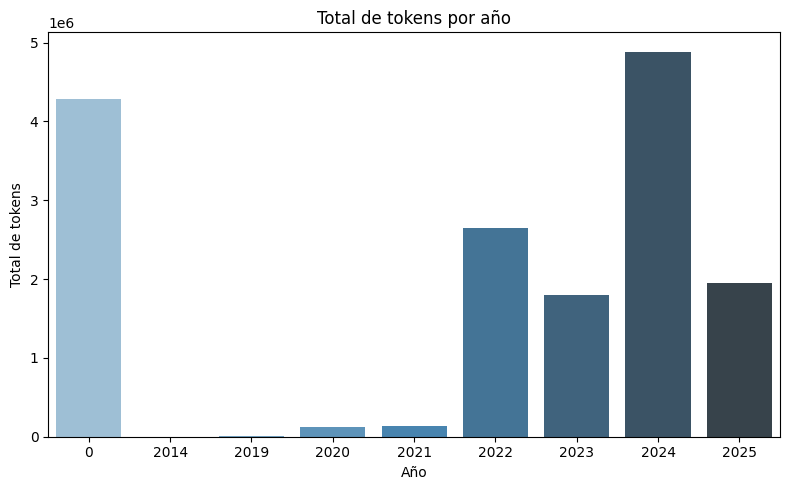

In [17]:
tokens_por_anio = df_all.groupby('year')['number_of_tokenks'].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=tokens_por_anio, x='year', y='number_of_tokenks', palette='Blues_d')
plt.title('Total de tokens por año')
plt.xlabel('Año')
plt.ylabel('Total de tokens')
plt.tight_layout()
plt.show()

/var/folders/0z/3s22b27525jc3bm0m923h36h3wg489/T/ipykernel_2826/2257267051.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=segundos_por_anio, x='year', y='duration', palette='Blues_d')


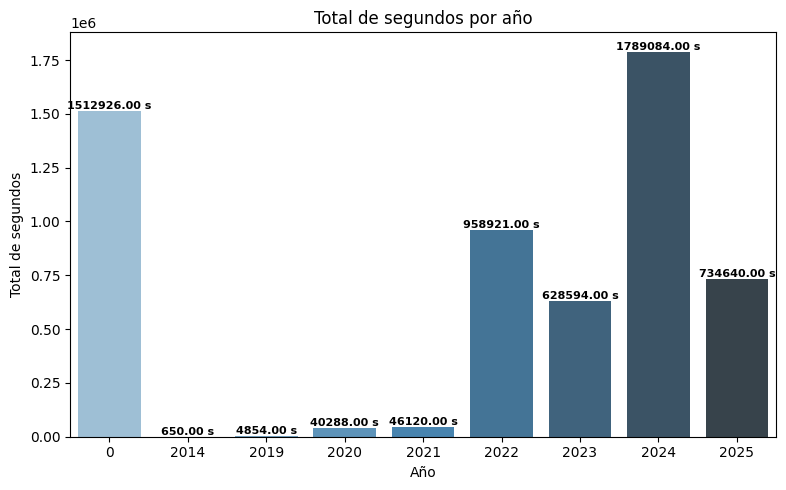

In [18]:
segundos_por_anio = df_all.groupby('year')['duration'].sum().reset_index()
font_size =16
plt.figure(figsize=(8,5))
ax = sns.barplot(data=segundos_por_anio, x='year', y='duration', palette='Blues_d')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f s', fontsize=font_size-8, fontweight='bold')
plt.title('Total de segundos por año')
plt.xlabel('Año')
plt.ylabel('Total de segundos')
plt.tight_layout()
plt.show()

/var/folders/0z/3s22b27525jc3bm0m923h36h3wg489/T/ipykernel_2826/2009650873.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=costo_gpt_41__por_anio[(costo_gpt_41__por_anio["year"]>2023) | (costo_gpt_41__por_anio["year"]==0)], x='year', y='cost_total', palette='Blues_d')


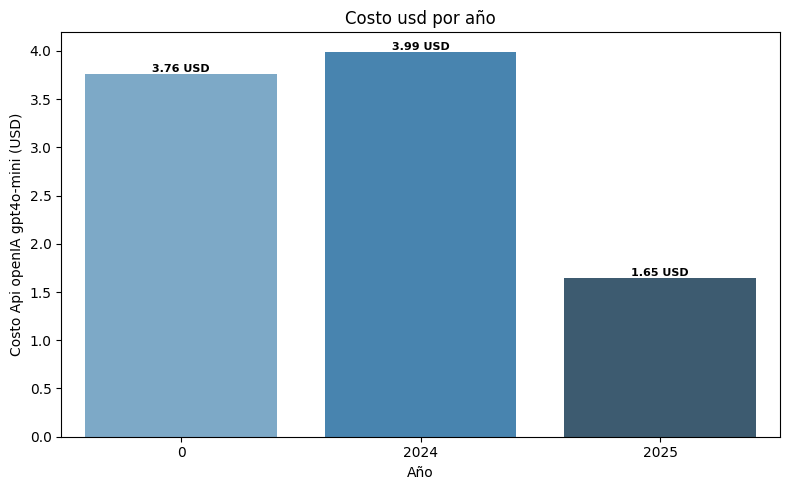

In [19]:
costo_gpt_41__por_anio = df_all.groupby('year')['cost_total'].sum().reset_index()

plt.figure(figsize=(8,5))
ax = sns.barplot(data=costo_gpt_41__por_anio[(costo_gpt_41__por_anio["year"]>2023) | (costo_gpt_41__por_anio["year"]==0)], x='year', y='cost_total', palette='Blues_d')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f USD', fontsize=font_size-8, fontweight='bold')
plt.title('Costo usd por año')
plt.xlabel('Año')
plt.ylabel('Costo Api openIA gpt4o-mini (USD)')
plt.tight_layout()
plt.show()

## Graficar barras: total de tokens por año y mes agrupados por canal

Agrupamos por 'channel_name', 'year' y 'month', sumamos 'number_of_tokenks' y graficamos con barras agrupadas.

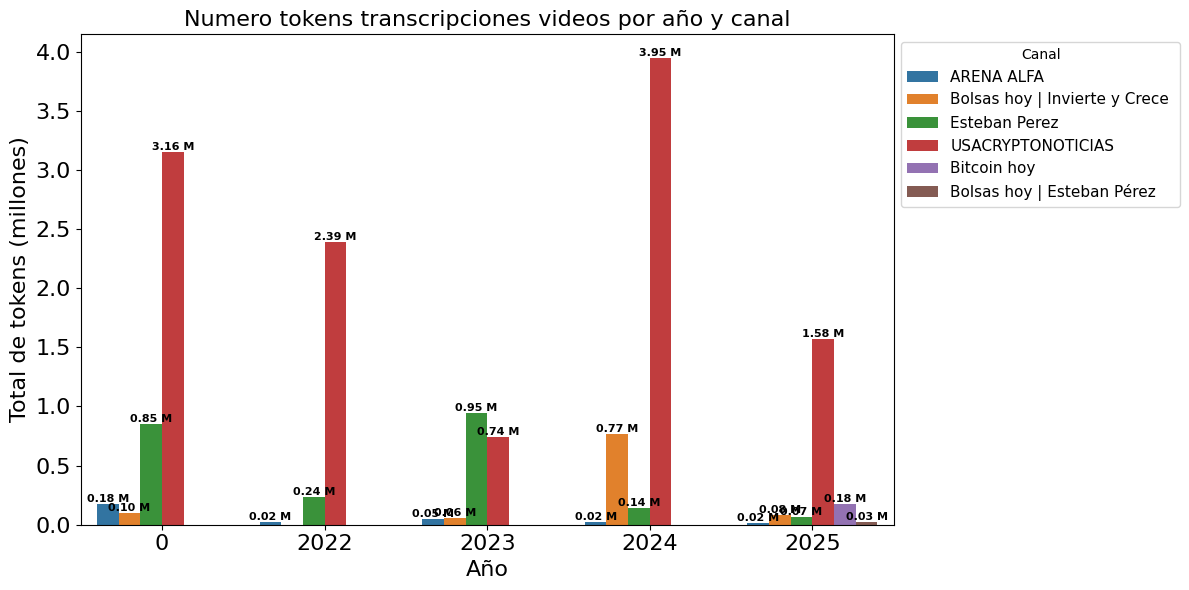

In [20]:
tokens_canal_anio_mes = (
    df_all[(df_all['year']>2021) | (df_all['year']==0) ].groupby(['channel_name', 'year'])['number_of_tokenks']
    .sum()
    .reset_index()
)

font_size = 16
tokens_canal_anio_mes['number_of_tokenks_millones'] = tokens_canal_anio_mes['number_of_tokenks'] / 1000000

plt.figure(figsize=(12,6))
ax = sns.barplot(
    data=tokens_canal_anio_mes,
    x='year',
    y='number_of_tokenks_millones',
    hue='channel_name'
)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f M', fontsize=font_size-8, fontweight='bold')
plt.title('Numero tokens transcripciones videos por año y canal', fontsize=font_size)
plt.xlabel('Año', fontsize=font_size)
plt.ylabel('Total de tokens (millones)', fontsize=font_size)
plt.legend(title='Canal', bbox_to_anchor=(1, 1), loc='upper left', fontsize=font_size-5)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.tight_layout()
plt.show()

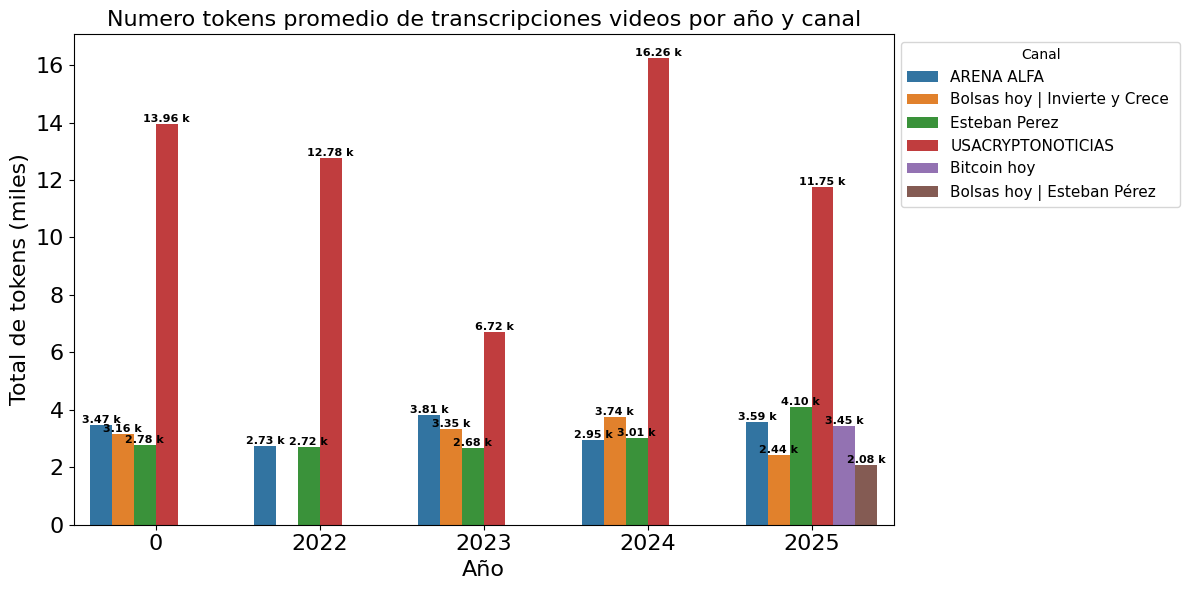

In [21]:
tokens_canal_anio_mes = (
    df_all[(df_all['year']>2021) | (df_all['year']==0) ].groupby(['channel_name', 'year'])['number_of_tokenks']
    .mean()
    .reset_index()
)

font_size = 16
tokens_canal_anio_mes['number_of_tokenks_miles'] = tokens_canal_anio_mes['number_of_tokenks'] / 1000

plt.figure(figsize=(12,6))
ax = sns.barplot(
    data=tokens_canal_anio_mes,
    x='year',
    y='number_of_tokenks_miles',
    hue='channel_name'
)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f k', fontsize=font_size-8, fontweight='bold')
plt.title('Numero tokens promedio de transcripciones videos por año y canal', fontsize=font_size)
plt.xlabel('Año', fontsize=font_size)
plt.ylabel('Total de tokens (miles)', fontsize=font_size)
plt.legend(title='Canal', bbox_to_anchor=(1, 1), loc='upper left', fontsize=font_size-5)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.tight_layout()
plt.show()

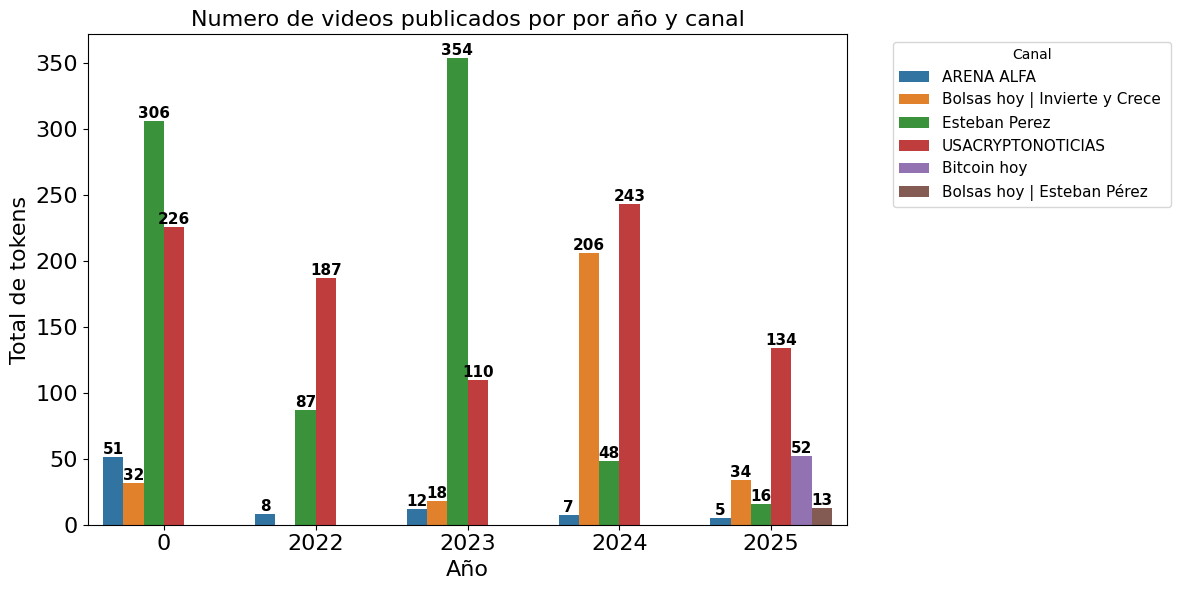

In [22]:
tokens_canal_anio_mes = (
    df_all[(df_all['year']>2021) | (df_all['year']==0)].groupby(['channel_name', 'year'])['video_id']
    .count()
    .reset_index()
)

font_size = 16


plt.figure(figsize=(12,6))
ax = sns.barplot(
    data=tokens_canal_anio_mes,
    x='year',
    y='video_id',
    hue='channel_name'
)
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', fontsize=font_size-5, fontweight='bold')
plt.title('Numero de videos publicados por por año y canal', fontsize=font_size)
plt.xlabel('Año', fontsize=font_size)
plt.ylabel('Total de tokens', fontsize=font_size)
plt.legend(title='Canal', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=font_size-5)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.tight_layout()
plt.show()

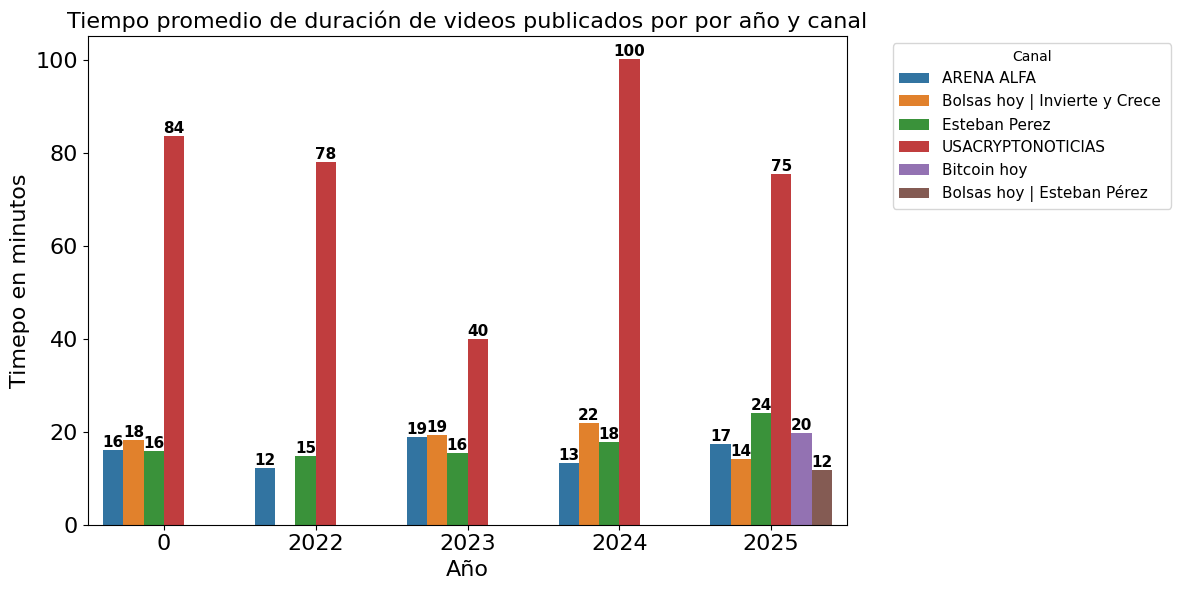

In [23]:
tokens_canal_anio_mes = (
    df_all[(df_all['year']>2021) | (df_all['year']==0)].groupby(['channel_name', 'year'])['duration']
    .mean()
    .reset_index()
)

font_size = 16
tokens_canal_anio_mes['duration_min'] = tokens_canal_anio_mes['duration'] / 60

plt.figure(figsize=(12,6))
ax = sns.barplot(
    data=tokens_canal_anio_mes,
    x='year',
    y='duration_min',
    hue='channel_name'
)
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', fontsize=font_size-5, fontweight='bold')
plt.title('Tiempo promedio de duración de videos publicados por por año y canal', fontsize=font_size)
plt.xlabel('Año', fontsize=font_size)
plt.ylabel('Timepo en minutos', fontsize=font_size)
plt.legend(title='Canal', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=font_size-5)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.tight_layout()
plt.show()

/var/folders/0z/3s22b27525jc3bm0m923h36h3wg489/T/ipykernel_2826/1456646201.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


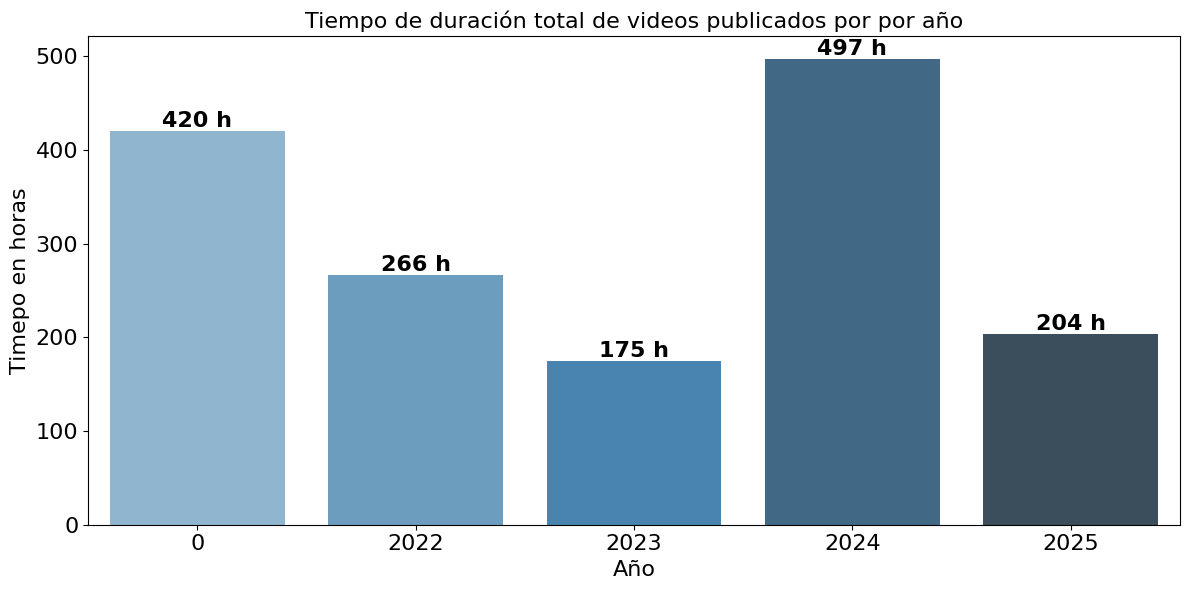

In [24]:
tokens_canal_anio_mes = (
    df_all[(df_all['year']>2021) | (df_all['year']==0)].groupby('year')['duration']
    .sum()
    .reset_index()
)
tokens_canal_anio_mes['duration_hour'] = tokens_canal_anio_mes['duration'] / 3600
font_size = 16


plt.figure(figsize=(12,6))
ax = sns.barplot(
    data=tokens_canal_anio_mes,
    x='year',
    y='duration_hour',
    palette='Blues_d'
)
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f h', fontsize=font_size, fontweight='bold')
plt.title('Tiempo de duración total de videos publicados por por año', fontsize=font_size)
plt.xlabel('Año', fontsize=font_size)
plt.ylabel('Timepo en horas', fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.tight_layout()
plt.show()

/var/folders/0z/3s22b27525jc3bm0m923h36h3wg489/T/ipykernel_2826/1856368176.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


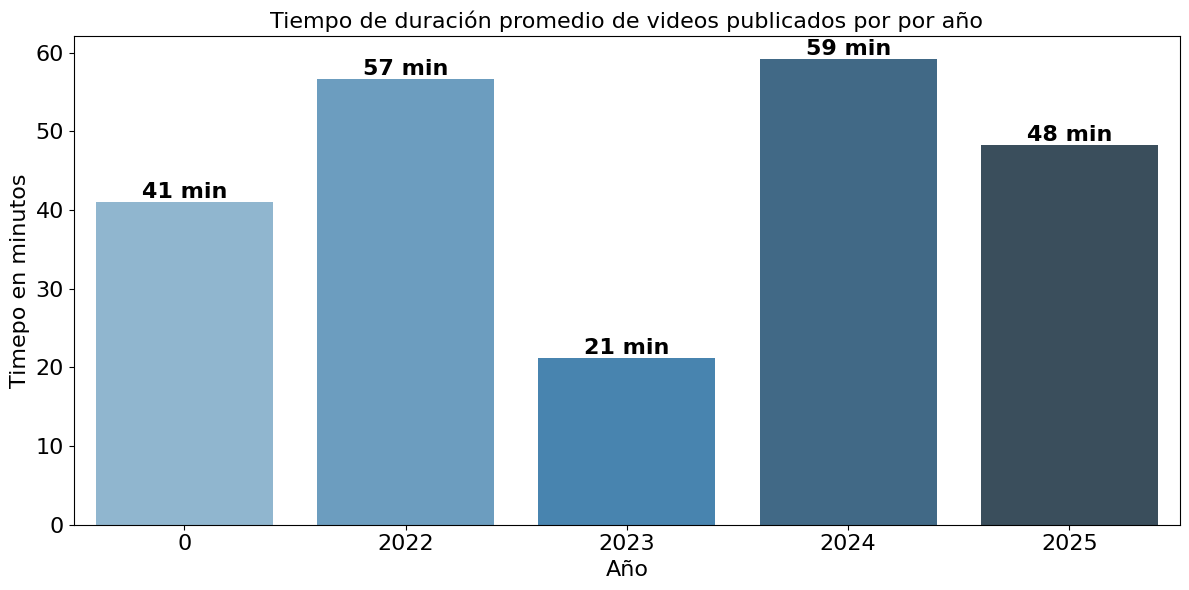

In [25]:
tokens_canal_anio_mes = (
    df_all[(df_all['year']>2021) | (df_all['year']==0)].groupby('year')['duration']
    .mean()
    .reset_index()
)
tokens_canal_anio_mes['duration_min'] = tokens_canal_anio_mes['duration'] / 60
font_size = 16


plt.figure(figsize=(12,6))
ax = sns.barplot(
    data=tokens_canal_anio_mes,
    x='year',
    y='duration_min',
    palette='Blues_d'
)
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f min', fontsize=font_size, fontweight='bold')
plt.title('Tiempo de duración promedio de videos publicados por por año', fontsize=font_size)
plt.xlabel('Año', fontsize=font_size)
plt.ylabel('Timepo en minutos', fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.tight_layout()
plt.show()

## Crear columna mes-año

Creamos una columna combinando 'year' y 'month' en formato 'YYYY-MM' para usar en el eje x del gráfico de líneas.

In [26]:
df_all['mes_anio'] = df_all.apply(
    lambda row: f"{int(row['year']):04d}-{int(row['month']):02d}" if row['year'] > 0 and row['month'] > 0 else None,
    axis=1
)

## Graficar líneas: tokens totales por mes-año

Agrupamos por la nueva columna 'mes-año', sumamos 'number_of_tokenks' y graficamos una línea con el tiempo en el eje x y tokens en el eje y.

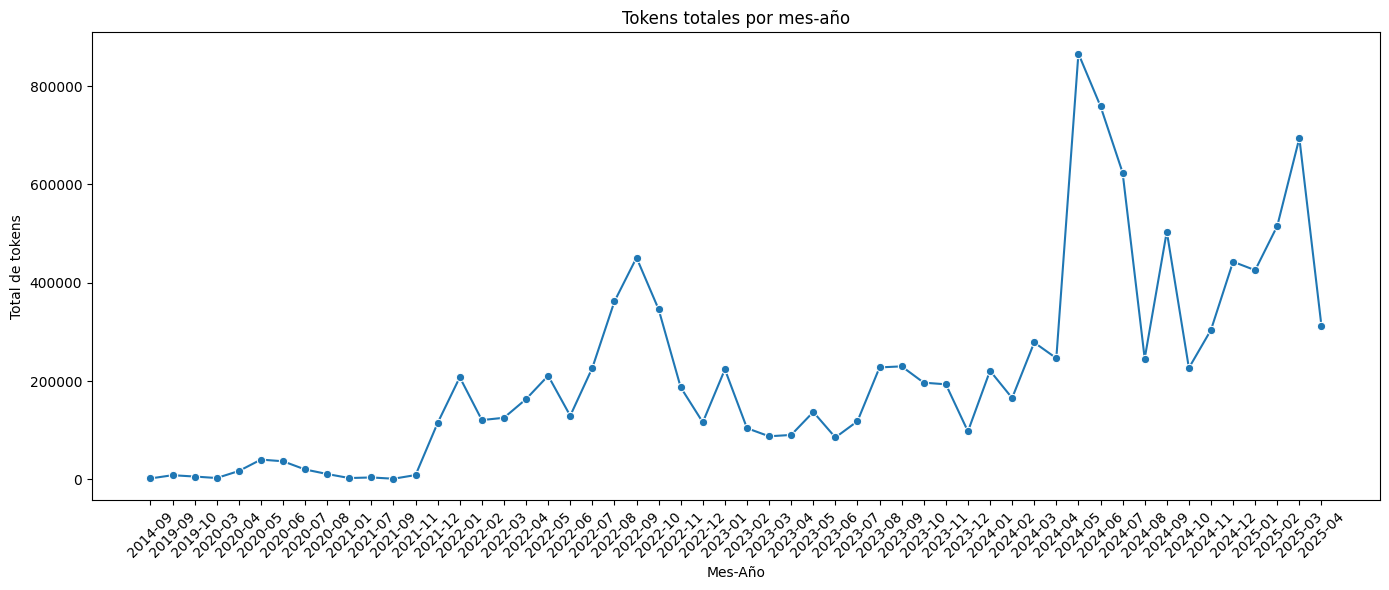

In [27]:
tokens_por_mes_anio = (
    df_all.dropna(subset=['mes_anio'])
    .groupby('mes_anio')['number_of_tokenks']
    .sum()
    .reset_index()
)

plt.figure(figsize=(14,6))
sns.lineplot(data=tokens_por_mes_anio, x='mes_anio', y='number_of_tokenks', marker='o')
plt.title('Tokens totales por mes-año')
plt.xlabel('Mes-Año')
plt.ylabel('Total de tokens')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

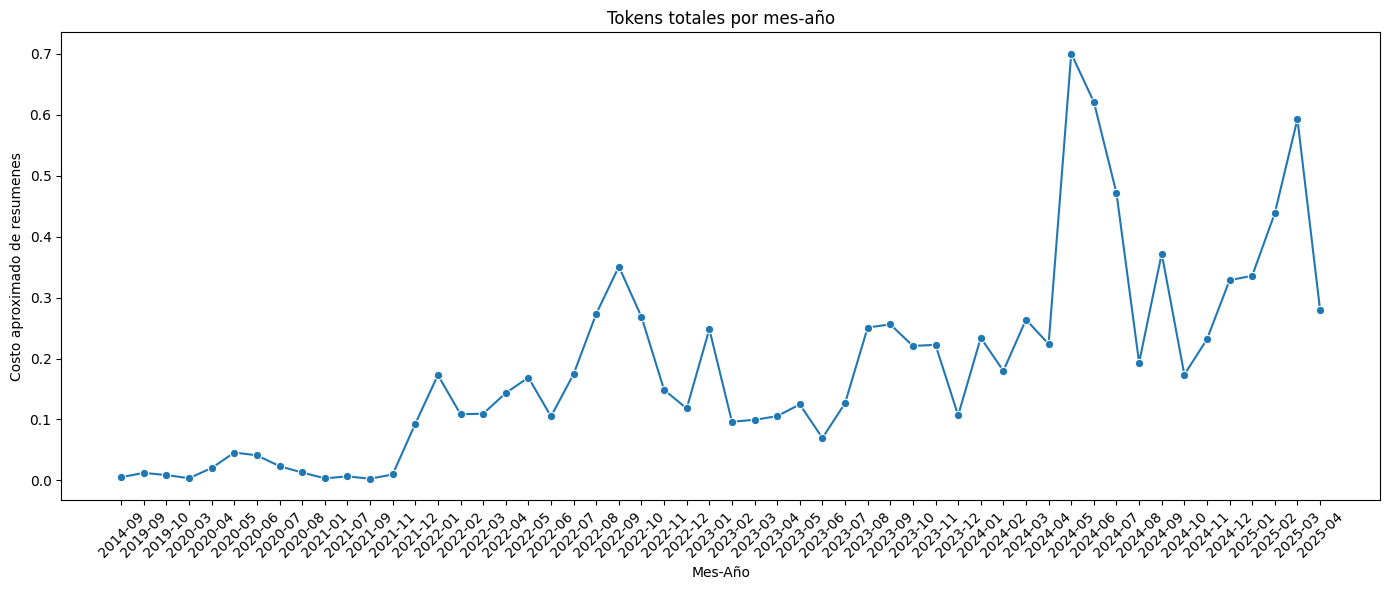

In [28]:
costo_por_mes_anio = (
    df_all.dropna(subset=['mes_anio'])
    .groupby('mes_anio')['cost_total']
    .sum()
    .reset_index()
)

plt.figure(figsize=(14,6))
sns.lineplot(data=costo_por_mes_anio, x='mes_anio', y='cost_total', marker='o')
plt.title('Tokens totales por mes-año')
plt.xlabel('Mes-Año')
plt.ylabel('Costo aproximado de resumenes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

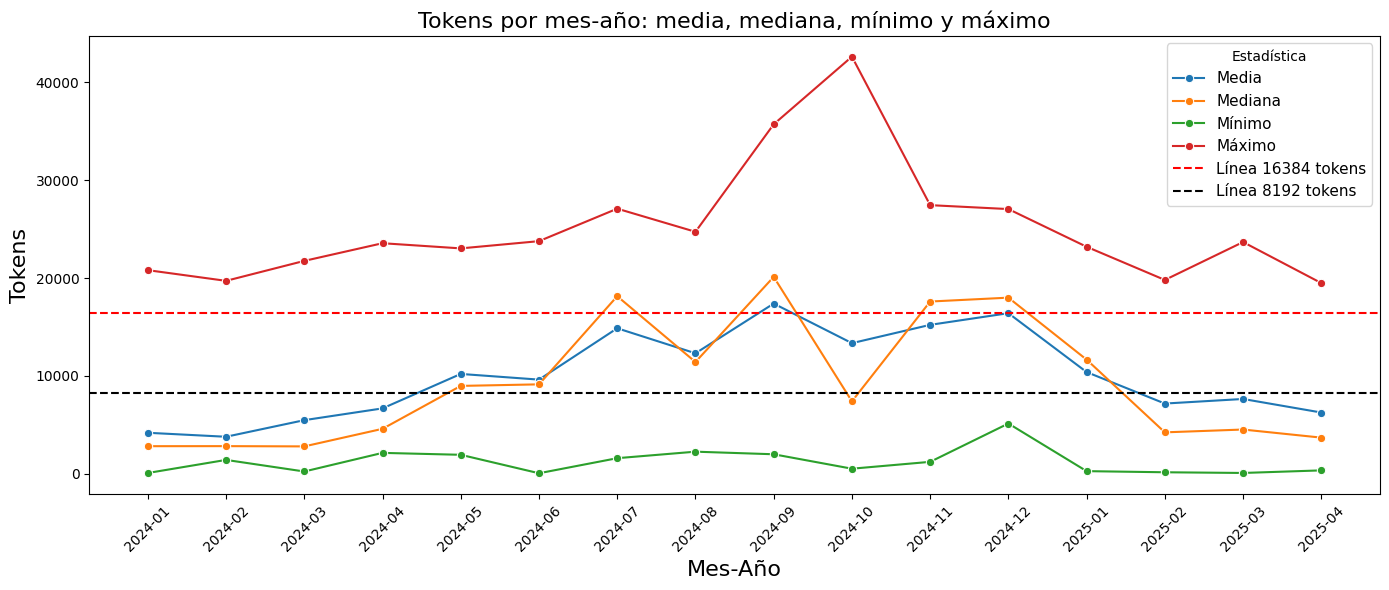

In [29]:
font_size = 16
linea_tokens =8192*2
linea_tokens_1 =8192

tokens_stats_mes_anio = (
    df_all[df_all['year']>=2024].dropna(subset=['mes_anio'])
    .groupby('mes_anio')['number_of_tokenks']
    .agg(['mean', 'median', 'min', 'max'])
    .reset_index()
)

plt.figure(figsize=(14,6))
sns.lineplot(data=tokens_stats_mes_anio, x='mes_anio', y='mean', marker='o', label='Media')
sns.lineplot(data=tokens_stats_mes_anio, x='mes_anio', y='median', marker='o', label='Mediana')
sns.lineplot(data=tokens_stats_mes_anio, x='mes_anio', y='min', marker='o', label='Mínimo')
sns.lineplot(data=tokens_stats_mes_anio, x='mes_anio', y='max', marker='o', label='Máximo')
plt.axhline(linea_tokens, color='red', linestyle='--', label=f'Línea {linea_tokens} tokens')
plt.axhline(linea_tokens_1, color='black', linestyle='--', label=f'Línea {linea_tokens_1} tokens')
plt.title('Tokens por mes-año: media, mediana, mínimo y máximo', fontsize=font_size)
plt.xlabel('Mes-Año', fontsize=font_size)
plt.ylabel('Tokens', fontsize=font_size)
plt.xticks(rotation=45)
plt.legend(title='Estadística',fontsize=font_size-5)
plt.tight_layout()
plt.show()

In [30]:
df_all['channel_name'].unique()

array(['Bolsas hoy | Invierte y Crece ', 'USACRYPTONOTICIAS',
       'Esteban Perez ', 'ARENA ALFA ', 'Bitcoin hoy',
       'Bolsas hoy | Esteban Pérez'], dtype=object)

In [37]:
linea_tokens_max = 8192  # Puedes cambiar este valor para mover la línea
linea_tokens = linea_tokens_max/2 
tokens_stats_mes_anio = (
    df_all[df_all['channel_name'] != 'USACRYPTONOTICIAS'].dropna(subset=['mes_anio'])
    .groupby('mes_anio')['number_of_tokenks']
    .agg(['mean', 'median', 'min', 'max'])
    .reset_index()
)
tokens_stats_mes_anio.describe()

,mean,median,min,max
count,53.000000,53.000000,53.000000,53.000000
mean,2869.679722,2716.320755,1360.660377,5601.849057
std,788.179461,764.734249,997.487400,3096.278414
min,530.250000,503.500000,156.000000,790.000000
25%,2449.458333,2401.000000,672.000000,3491.000000
50%,2897.000000,2695.000000,1116.000000,4594.000000
75%,3307.750000,3019.000000,1822.000000,6012.000000
max,5120.000000,5120.000000,5120.000000,13594.000000


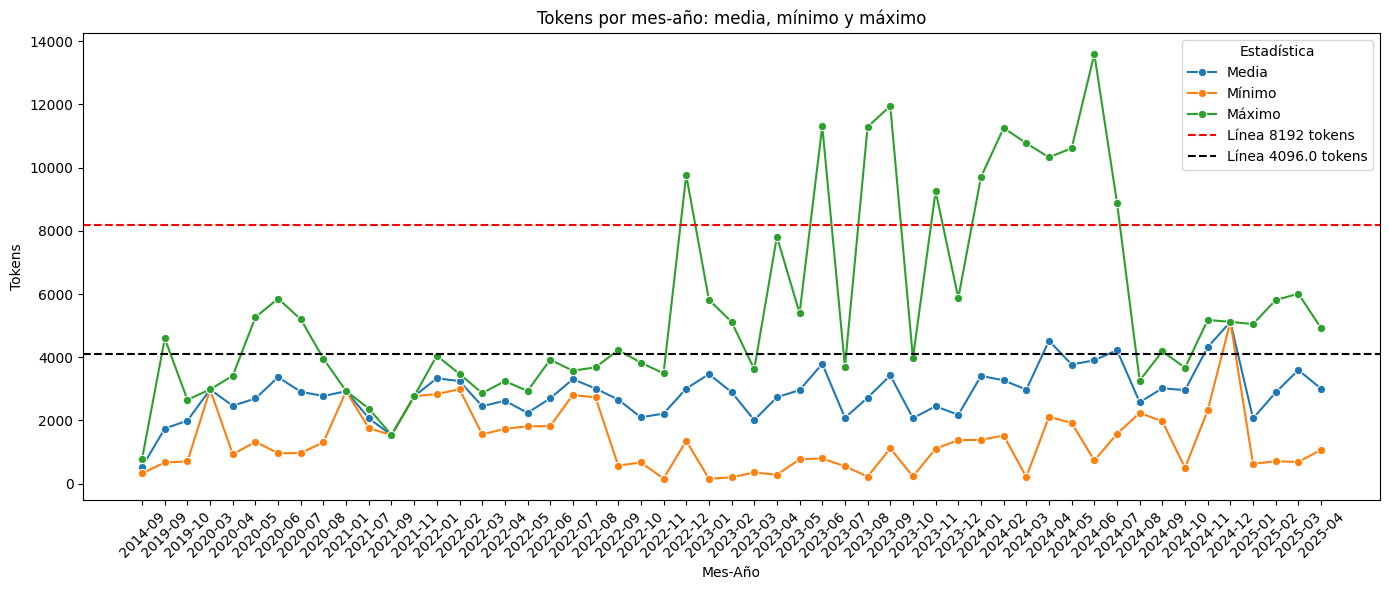

In [38]:
plt.figure(figsize=(14,6))
sns.lineplot(data=tokens_stats_mes_anio, x='mes_anio', y='mean', marker='o', label='Media')
#sns.lineplot(data=tokens_stats_mes_anio, x='mes_anio', y='median', marker='o', label='Mediana')
sns.lineplot(data=tokens_stats_mes_anio, x='mes_anio', y='min', marker='o', label='Mínimo')
sns.lineplot(data=tokens_stats_mes_anio, x='mes_anio', y='max', marker='o', label='Máximo')
plt.axhline(linea_tokens_max, color='red', linestyle='--', label=f'Línea {linea_tokens_max} tokens')
plt.axhline(linea_tokens, color='black', linestyle='--', label=f'Línea {linea_tokens} tokens')
plt.title('Tokens por mes-año: media, mínimo y máximo')
plt.xlabel('Mes-Año')
plt.ylabel('Tokens')
plt.xticks(rotation=45)
plt.legend(title='Estadística')
plt.tight_layout()
plt.show()

In [39]:
df_all['duration_min'] = df_all['duration'] / 60

In [40]:
duration_stats_mes_anio = (
    df_all[df_all['channel_name'] != 'USACRYPTONOTICIAS'].dropna(subset=['mes_anio'])
    .groupby('mes_anio')['duration_min']
    .agg(['mean', 'median', 'min', 'max'])
    .reset_index()
)
duration_stats_mes_anio.describe()

,mean,median,min,max
count,53.000000,53.000000,53.000000,53.000000
mean,15.986488,15.234119,7.325786,31.636164
std,4.867749,4.729044,5.800291,18.342352
min,2.708333,2.575000,0.000000,4.016667
25%,12.749242,13.025000,3.683333,19.566667
50%,15.568788,14.758333,6.683333,26.050000
75%,18.766667,17.166667,10.066667,35.100000
max,31.783333,31.783333,31.783333,77.866667


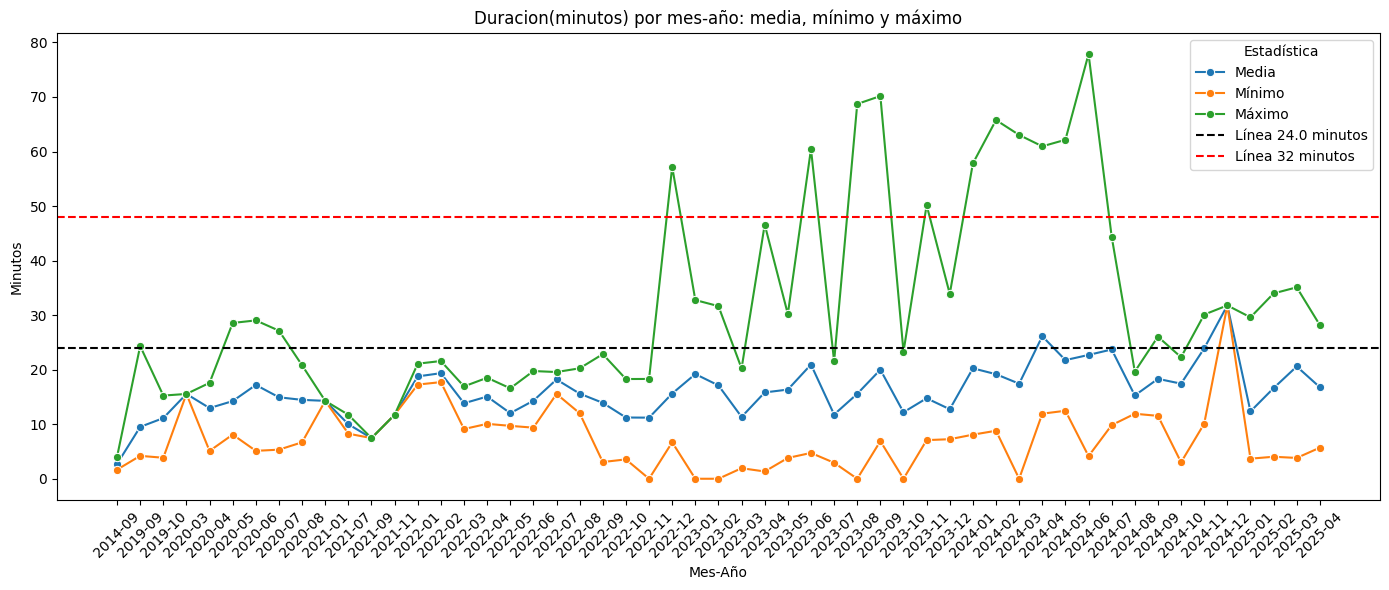

In [47]:
linea_min = 48/2#4672  # Puedes cambiar este valor para mover la línea



plt.figure(figsize=(14,6))
sns.lineplot(data=duration_stats_mes_anio, x='mes_anio', y='mean', marker='o', label='Media')
#sns.lineplot(data=duration_stats_mes_anio, x='mes_anio', y='median', marker='o', label='Mediana')
sns.lineplot(data=duration_stats_mes_anio, x='mes_anio', y='min', marker='o', label='Mínimo')
sns.lineplot(data=duration_stats_mes_anio, x='mes_anio', y='max', marker='o', label='Máximo')
plt.axhline(linea_min, color='black', linestyle='--', label=f'Línea {linea_min} minutos')
plt.axhline(48, color='red', linestyle='--', label=f'Línea {32} minutos')
plt.title('Duracion(minutos) por mes-año: media, mínimo y máximo')
plt.xlabel('Mes-Año')
plt.ylabel('Minutos')
plt.xticks(rotation=45)
plt.legend(title='Estadística')
plt.tight_layout()
plt.show()